<a href="https://colab.research.google.com/github/neerja198/Meal-Consumption-in-Flight/blob/master/Meal_Consumption_In_Flight_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Used for installing packages
# ! pip install plotly

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Data Reading

In [0]:
consumption_raw_data = pd.read_excel("/content/sector_consumption_raw.xlsx",index_col=0) # (5660, 90)
consumption_raw_data

#Que:what is the use of index_col = 0

,Flight Number,Arrival Time,From Airport,Offset Arrival,Offset Departure,Departure Time,To Airport,Pax_Eco,Pax_Bus,6 pralines for 4,Afterwork Deal,Aigle les Murailles blanc,Aigle les Murailles rouge,Apple-cinnamon tartlet,Bacardi Carta Blanca,Baccarat Brut,Baked Pretzel,Biere des Romands,Bombay Sapphire,Breakfast Deal,Cafe Gourmand,Cailler Branche Cremant L,Cailler Branche L,Cailler Branche deal,Caotina Hot Chocolate,Cheese Fondue,Chocolate chip cookies,ClubSW,Coca Cola,Coca Cola Zero,Dewars Whisky,Discount,Double Oat beer,Etter Johnett Swiss Whiskey,Fever Tree Tonic,Flutes a l'Ancienne,Focaccia SW,Fruit Mix,Geneva Tomatoe Juice,Henniez Sparkling,...,Lavazza Coffee,Lunch Deal club/chips/San Pellegrino,Lunch Deal sandwich and San Pellegrino,Lunch Deal sandwich/chips/San Pellegrino,Manuel 3 pralines,Manuel 4 Pralines,Michel orange juice,Michel tomato juice,Muffin,Mulled Wine,Nestea Lemon,OUT Dessert,PAKKA BIO salted & roasted almonds,Pain au Chocolat,Planchette + bread,Quollfrisch,Raspberry Macaroon,SW of Month,Salted caramel cookie,SanPellegrino Aranciata,SanPellegrino Lemon,Schweppes Tonic Water,Senza Parole Primitivo Salento,Sirocco Ceylon Sunrise,Sirocco Earl Grey,Sirocco Ginger Lemon,Sirocco Japanese Sencha,Sirocco Spearmint,Smirnoff Red Label,Speronza Assemblage Blanc VdP Romand,Speronza Assemblage Rouge,Starling Chasselas,Sweet Treat,Swiss Aperitif,Tartlet,Treat Yourself Deal,Vaya Beans,Williamine,Zweifel Nature,Zweifel Paprika
Flight Day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-11-01,LX1080,08:25,GVA,+01:00,+01:00,07:10,FRA,60.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaT,LX1081,10:10,FRA,+01:00,+01:00,09:05,GVA,96.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaT,LX1082,12:05,GVA,+01:00,+01:00,10:50,FRA,62.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaT,LX1083,14:15,FRA,+01:00,+01:00,13:10,GVA,68.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaT,LX1084,16:10,GVA,+01:00,+01:00,14:55,FRA,101.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaT,LX359,08:35,LHR,+00:00,+00:00,07:00,GVA,115.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaT,LX410,13:00,GVA,+00:00,+01:00,11:45,DUB,105.0,4.0,NaN,Na

# Data Investigation and Cleaning

Deleting rows where no consumption happened at all

In [0]:
consumption_raw_data = consumption_raw_data [consumption_raw_data.iloc[:,10:-1].sum(axis = 1) > 0]
consumption_raw_data.shape

(3401, 90)

#### Keep only columns and meals we want to predict 

In [0]:
consumption_raw_data.reset_index(inplace = True)

In [0]:
columns_to_keep = ["Flight Day",'Flight Number', 'Arrival Time', 'From Airport', 'Departure Time', 'To Airport', 'Pax_Eco',
                   'ClubSW', 'Focaccia SW', 'Muffin', 'Pain au Chocolat', 'Planchette + bread', 'SW of Month']

In [0]:
consumption_raw_data = consumption_raw_data[columns_to_keep]

In [0]:
consumption_raw_data.head(2)

,Flight Day,Flight Number,Arrival Time,From Airport,Departure Time,To Airport,Pax_Eco,ClubSW,Focaccia SW,Muffin,Pain au Chocolat,Planchette + bread,SW of Month
0,NaT,LX1336,13:35,GVA,08:00,DME,58.0,4.0,1.0,NaN,2.0,NaN,NaN
1,NaT,LX1337,16:15,DME,14:20,GVA,109.0,4.0,6.0,NaN,NaN,NaN,6.0


#### Renaming the columns in the dataset

In [0]:
consumption_raw_data.rename(columns={'Pax_Eco':'Pax', 'ClubSW':'Meal1','SW of Month':'Meal2',
                                     'Focaccia SW':'Meal3', 'Muffin':'Meal4','Planchette + bread':'Meal5',
                                     'Pain au Chocolat':'Meal6'}, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
consumption_raw_data.rename(columns={'Pax_Eco':'Pax', 'ClubSW':'Meal1','SW of Month':'Meal2','Planchette + bread':'Meal5','Focaccia SW':'Meal3', 'Muffin':'Meal4','Pain au Chocolat':'Meal6'}, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


#### Reset the index to make Flight Day as a column

In [0]:
#to make flight date as a feature and use it to get some info 
#Generate a new DataFrame or Series with the index reset.
#This is useful when the index needs to be treated as a column, or when the index is meaningless and needs to be reset to the default before another operation.

consumption_raw_data.reset_index(inplace = True)
#Que:why we are doing reset_index here


In [0]:
consumption_raw_data.tail()

,Flight Day,Flight Number,Arrival Time,From Airport,Offset Arrival,Offset Departure,Departure Time,To Airport,Pax,Pax_Bus,6 pralines for 4,Afterwork Deal,Aigle les Murailles blanc,Aigle les Murailles rouge,Apple-cinnamon tartlet,Bacardi Carta Blanca,Baccarat Brut,Baked Pretzel,Biere des Romands,Bombay Sapphire,Breakfast Deal,Cafe Gourmand,Cailler Branche Cremant L,Cailler Branche L,Cailler Branche deal,Caotina Hot Chocolate,Cheese Fondue,Chocolate chip cookies,Meal1,Coca Cola,Coca Cola Zero,Dewars Whisky,Discount,Double Oat beer,Etter Johnett Swiss Whiskey,Fever Tree Tonic,Flutes a l'Ancienne,Meal3,Fruit Mix,Geneva Tomatoe Juice,...,Lavazza Coffee,Lunch Deal club/chips/San Pellegrino,Lunch Deal sandwich and San Pellegrino,Lunch Deal sandwich/chips/San Pellegrino,Manuel 3 pralines,Manuel 4 Pralines,Michel orange juice,Michel tomato juice,Meal4,Mulled Wine,Nestea Lemon,OUT Dessert,PAKKA BIO salted & roasted almonds,Meal6,Meal5,Quollfrisch,Raspberry Macaroon,Meal2,Salted caramel cookie,SanPellegrino Aranciata,SanPellegrino Lemon,Schweppes Tonic Water,Senza Parole Primitivo Salento,Sirocco Ceylon Sunrise,Sirocco Earl Grey,Sirocco Ginger Lemon,Sirocco Japanese Sencha,Sirocco Spearmint,Smirnoff Red Label,Speronza Assemblage Blanc VdP Romand,Speronza Assemblage Rouge,Starling Chasselas,Sweet Treat,Swiss Aperitif,Tartlet,Treat Yourself Deal,Vaya Beans,Williamine,Zweifel Nature,Zweifel Paprika
3396,NaT,LX357,22:05,LHR,+01:00,+00:00,19:30,GVA,56.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3397,NaT,LX358,21:25,GVA,+00:00,+01:00,20:50,LHR,102.0,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3398,NaT,LX359,08:35,LHR,+00:00,+00:00,07:00,GVA,115.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3399,NaT,LX434,11:30,GVA,+00:00,+01:00,10:55,LCY,83.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
3400,NaT,LX435,14:35,LCY,+01:00,+00:00,12:00,GVA,99.0,5.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1.0,NaN,NaN,NaN,NaN,NaN,5.0,1.0,1.0,NaN,1.0,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN,NaN,3.0,1.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0


In [0]:
# consumption_raw_data['Flight Day'].value_counts()
# consumption_raw_data.isna().sum()



#### After some investigation we have to forward fill the flight day and to fill NaNs in meals(1-6) with zero

#### Replace Nan values in flight day column with the correct flight day

In [0]:

# consumption_raw_data['Flight Day'].fillna(method='ffill', inplace = True)

In [0]:
# Replace Nan values in meals with the 0
consumption_raw_data['Meal1'].fillna(0, inplace = True)
consumption_raw_data['Meal2'].fillna(0, inplace = True)
consumption_raw_data['Meal3'].fillna(0, inplace = True)
consumption_raw_data['Meal4'].fillna(0, inplace = True)
consumption_raw_data['Meal5'].fillna(0, inplace = True)
consumption_raw_data['Meal6'].fillna(0, inplace = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [0]:
consumption_raw_data.tail()

,Flight Day,Flight Number,Arrival Time,From Airport,Offset Arrival,Offset Departure,Departure Time,To Airport,Pax,Pax_Bus,6 pralines for 4,Afterwork Deal,Aigle les Murailles blanc,Aigle les Murailles rouge,Apple-cinnamon tartlet,Bacardi Carta Blanca,Baccarat Brut,Baked Pretzel,Biere des Romands,Bombay Sapphire,Breakfast Deal,Cafe Gourmand,Cailler Branche Cremant L,Cailler Branche L,Cailler Branche deal,Caotina Hot Chocolate,Cheese Fondue,Chocolate chip cookies,Meal1,Coca Cola,Coca Cola Zero,Dewars Whisky,Discount,Double Oat beer,Etter Johnett Swiss Whiskey,Fever Tree Tonic,Flutes a l'Ancienne,Meal3,Fruit Mix,Geneva Tomatoe Juice,...,Lavazza Coffee,Lunch Deal club/chips/San Pellegrino,Lunch Deal sandwich and San Pellegrino,Lunch Deal sandwich/chips/San Pellegrino,Manuel 3 pralines,Manuel 4 Pralines,Michel orange juice,Michel tomato juice,Meal4,Mulled Wine,Nestea Lemon,OUT Dessert,PAKKA BIO salted & roasted almonds,Meal6,Meal5,Quollfrisch,Raspberry Macaroon,Meal2,Salted caramel cookie,SanPellegrino Aranciata,SanPellegrino Lemon,Schweppes Tonic Water,Senza Parole Primitivo Salento,Sirocco Ceylon Sunrise,Sirocco Earl Grey,Sirocco Ginger Lemon,Sirocco Japanese Sencha,Sirocco Spearmint,Smirnoff Red Label,Speronza Assemblage Blanc VdP Romand,Speronza Assemblage Rouge,Starling Chasselas,Sweet Treat,Swiss Aperitif,Tartlet,Treat Yourself Deal,Vaya Beans,Williamine,Zweifel Nature,Zweifel Paprika
3396,NaT,LX357,22:05,LHR,+01:00,+00:00,19:30,GVA,56.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,1.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3397,NaT,LX358,21:25,GVA,+00:00,+01:00,20:50,LHR,102.0,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3398,NaT,LX359,08:35,LHR,+00:00,+00:00,07:00,GVA,115.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,5.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3399,NaT,LX434,11:30,GVA,+00:00,+01:00,10:55,LCY,83.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
3400,NaT,LX435,14:35,LCY,+01:00,+00:00,12:00,GVA,99.0,5.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1.0,NaN,NaN,NaN,NaN,NaN,5.0,1.0,1.0,NaN,1.0,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,3.0,1.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0


#### We see some Nans in some of the columns

In [0]:
consumption_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3401 entries, 0 to 3400
Data columns (total 91 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   Flight Day                                2 non-null      datetime64[ns]
 1   Flight Number                             3401 non-null   object        
 2   Arrival Time                              3362 non-null   object        
 3   From Airport                              3362 non-null   object        
 4   Offset Arrival                            3362 non-null   object        
 5   Offset Departure                          3362 non-null   object        
 6   Departure Time                            3362 non-null   object        
 7   To Airport                                3362 non-null   object        
 8   Pax                                       3362 non-null   float64       
 9   Pax_Bus                       

In [0]:
start = 0
consumption_raw_data.iloc[start : start + 10:]
#To see random sample of the data 

,Flight Day,Flight Number,Arrival Time,From Airport,Offset Arrival,Offset Departure,Departure Time,To Airport,Pax,Pax_Bus,6 pralines for 4,Afterwork Deal,Aigle les Murailles blanc,Aigle les Murailles rouge,Apple-cinnamon tartlet,Bacardi Carta Blanca,Baccarat Brut,Baked Pretzel,Biere des Romands,Bombay Sapphire,Breakfast Deal,Cafe Gourmand,Cailler Branche Cremant L,Cailler Branche L,Cailler Branche deal,Caotina Hot Chocolate,Cheese Fondue,Chocolate chip cookies,Meal1,Coca Cola,Coca Cola Zero,Dewars Whisky,Discount,Double Oat beer,Etter Johnett Swiss Whiskey,Fever Tree Tonic,Flutes a l'Ancienne,Meal3,Fruit Mix,Geneva Tomatoe Juice,...,Lavazza Coffee,Lunch Deal club/chips/San Pellegrino,Lunch Deal sandwich and San Pellegrino,Lunch Deal sandwich/chips/San Pellegrino,Manuel 3 pralines,Manuel 4 Pralines,Michel orange juice,Michel tomato juice,Meal4,Mulled Wine,Nestea Lemon,OUT Dessert,PAKKA BIO salted & roasted almonds,Meal6,Meal5,Quollfrisch,Raspberry Macaroon,Meal2,Salted caramel cookie,SanPellegrino Aranciata,SanPellegrino Lemon,Schweppes Tonic Water,Senza Parole Primitivo Salento,Sirocco Ceylon Sunrise,Sirocco Earl Grey,Sirocco Ginger Lemon,Sirocco Japanese Sencha,Sirocco Spearmint,Smirnoff Red Label,Speronza Assemblage Blanc VdP Romand,Speronza Assemblage Rouge,Starling Chasselas,Sweet Treat,Swiss Aperitif,Tartlet,Treat Yourself Deal,Vaya Beans,Williamine,Zweifel Nature,Zweifel Paprika
0,NaT,LX1336,13:35,GVA,+03:00,+01:00,08:00,DME,58.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,NaN,NaN,2.0,0.0,13.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1,NaT,LX1337,16:15,DME,+01:00,+03:00,14:20,GVA,109.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,1.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,6.0,1.0,NaN,...,8.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,3.0,0.0,0.0,2.0,NaN,6.0,NaN,NaN,1.0,NaN,8.0,1.0,1.0,NaN,NaN,2.0,NaN,7.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,3.0,2.0
2,NaT,LX1472,09:40,GVA,+01:00,+01:00,08:10,PRG,136.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,2.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaT,LX1822,16:00,GVA,+02:00,+01:00,12:20,ATH,106.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,2.0,11.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,NaN,...,6.0,NaN,2.0,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,1.0,0.0,2.0,NaN,NaN,9.0,NaN,1.0,3.0,NaN,4.0,2.0,NaN,NaN,NaN,NaN,NaN,1.0,3.0,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,3.0
4,NaT,LX1823,18:35,ATH,+01:00,+02:00,16:40,GVA,145.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
5,NaT,LX1946,18:35,GVA,+01:00,+01:00,17:05,BCN,66.0,5.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,1.0,2.0,0.0,NaN,NaN,NaN,1.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN
6,NaT,LX1947,20:45,BCN,+01:00,+01:00,19:15,GVA,129.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,2.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaT,LX2048,20:20,GVA,+01:00,+01:00,18:20,MAD,124.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,5.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,Na

In [0]:
is_NaN = consumption_raw_data.isnull()

row_has_NaN = is_NaN.any(axis=1)

rows_with_NaN = consumption_raw_data[row_has_NaN]

rows_with_NaN.shape

(3401, 91)

#### 39 rows with Nans in (Arrival Time, From Airport, Departure Time, To Airport, Pax)

**Que:Why we are considering 39 rows with Nans only, how would we know this ?**

In [0]:
rows_with_NaN.head(5)

,Flight Day,Flight Number,Arrival Time,From Airport,Offset Arrival,Offset Departure,Departure Time,To Airport,Pax,Pax_Bus,6 pralines for 4,Afterwork Deal,Aigle les Murailles blanc,Aigle les Murailles rouge,Apple-cinnamon tartlet,Bacardi Carta Blanca,Baccarat Brut,Baked Pretzel,Biere des Romands,Bombay Sapphire,Breakfast Deal,Cafe Gourmand,Cailler Branche Cremant L,Cailler Branche L,Cailler Branche deal,Caotina Hot Chocolate,Cheese Fondue,Chocolate chip cookies,Meal1,Coca Cola,Coca Cola Zero,Dewars Whisky,Discount,Double Oat beer,Etter Johnett Swiss Whiskey,Fever Tree Tonic,Flutes a l'Ancienne,Meal3,Fruit Mix,Geneva Tomatoe Juice,...,Lavazza Coffee,Lunch Deal club/chips/San Pellegrino,Lunch Deal sandwich and San Pellegrino,Lunch Deal sandwich/chips/San Pellegrino,Manuel 3 pralines,Manuel 4 Pralines,Michel orange juice,Michel tomato juice,Meal4,Mulled Wine,Nestea Lemon,OUT Dessert,PAKKA BIO salted & roasted almonds,Meal6,Meal5,Quollfrisch,Raspberry Macaroon,Meal2,Salted caramel cookie,SanPellegrino Aranciata,SanPellegrino Lemon,Schweppes Tonic Water,Senza Parole Primitivo Salento,Sirocco Ceylon Sunrise,Sirocco Earl Grey,Sirocco Ginger Lemon,Sirocco Japanese Sencha,Sirocco Spearmint,Smirnoff Red Label,Speronza Assemblage Blanc VdP Romand,Speronza Assemblage Rouge,Starling Chasselas,Sweet Treat,Swiss Aperitif,Tartlet,Treat Yourself Deal,Vaya Beans,Williamine,Zweifel Nature,Zweifel Paprika
0,NaT,LX1336,13:35,GVA,+03:00,+01:00,08:00,DME,58.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,NaN,NaN,2.0,0.0,13.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1,NaT,LX1337,16:15,DME,+01:00,+03:00,14:20,GVA,109.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,1.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,6.0,1.0,NaN,...,8.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,3.0,0.0,0.0,2.0,NaN,6.0,NaN,NaN,1.0,NaN,8.0,1.0,1.0,NaN,NaN,2.0,NaN,7.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,3.0,2.0
2,NaT,LX1472,09:40,GVA,+01:00,+01:00,08:10,PRG,136.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,2.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaT,LX1822,16:00,GVA,+02:00,+01:00,12:20,ATH,106.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,2.0,11.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,NaN,...,6.0,NaN,2.0,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,1.0,0.0,2.0,NaN,NaN,9.0,NaN,1.0,3.0,NaN,4.0,2.0,NaN,NaN,NaN,NaN,NaN,1.0,3.0,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,3.0
4,NaT,LX1823,18:35,ATH,+01:00,+02:00,16:40,GVA,145.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


#### Samples of rows_with_NaN

In [0]:
consumption_raw_data.head()

,Flight Day,Flight Number,Arrival Time,From Airport,Offset Arrival,Offset Departure,Departure Time,To Airport,Pax,Pax_Bus,6 pralines for 4,Afterwork Deal,Aigle les Murailles blanc,Aigle les Murailles rouge,Apple-cinnamon tartlet,Bacardi Carta Blanca,Baccarat Brut,Baked Pretzel,Biere des Romands,Bombay Sapphire,Breakfast Deal,Cafe Gourmand,Cailler Branche Cremant L,Cailler Branche L,Cailler Branche deal,Caotina Hot Chocolate,Cheese Fondue,Chocolate chip cookies,Meal1,Coca Cola,Coca Cola Zero,Dewars Whisky,Discount,Double Oat beer,Etter Johnett Swiss Whiskey,Fever Tree Tonic,Flutes a l'Ancienne,Meal3,Fruit Mix,Geneva Tomatoe Juice,...,Lavazza Coffee,Lunch Deal club/chips/San Pellegrino,Lunch Deal sandwich and San Pellegrino,Lunch Deal sandwich/chips/San Pellegrino,Manuel 3 pralines,Manuel 4 Pralines,Michel orange juice,Michel tomato juice,Meal4,Mulled Wine,Nestea Lemon,OUT Dessert,PAKKA BIO salted & roasted almonds,Meal6,Meal5,Quollfrisch,Raspberry Macaroon,Meal2,Salted caramel cookie,SanPellegrino Aranciata,SanPellegrino Lemon,Schweppes Tonic Water,Senza Parole Primitivo Salento,Sirocco Ceylon Sunrise,Sirocco Earl Grey,Sirocco Ginger Lemon,Sirocco Japanese Sencha,Sirocco Spearmint,Smirnoff Red Label,Speronza Assemblage Blanc VdP Romand,Speronza Assemblage Rouge,Starling Chasselas,Sweet Treat,Swiss Aperitif,Tartlet,Treat Yourself Deal,Vaya Beans,Williamine,Zweifel Nature,Zweifel Paprika
0,NaT,LX1336,13:35,GVA,+03:00,+01:00,08:00,DME,58.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,NaN,NaN,2.0,0.0,13.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1,NaT,LX1337,16:15,DME,+01:00,+03:00,14:20,GVA,109.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,1.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,6.0,1.0,NaN,...,8.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,3.0,0.0,0.0,2.0,NaN,6.0,NaN,NaN,1.0,NaN,8.0,1.0,1.0,NaN,NaN,2.0,NaN,7.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,3.0,2.0
2,NaT,LX1472,09:40,GVA,+01:00,+01:00,08:10,PRG,136.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,2.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaT,LX1822,16:00,GVA,+02:00,+01:00,12:20,ATH,106.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,2.0,11.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,NaN,...,6.0,NaN,2.0,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,1.0,0.0,2.0,NaN,NaN,9.0,NaN,1.0,3.0,NaN,4.0,2.0,NaN,NaN,NaN,NaN,NaN,1.0,3.0,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,3.0
4,NaT,LX1823,18:35,ATH,+01:00,+02:00,16:40,GVA,145.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [0]:
# consumption_raw_data['Offset Arrival'] = consumption_raw_data['Offset Arrival'].str.replace('+','')
# consumption_raw_data['Offset Departure'] = consumption_raw_data['Offset Departure'].str.replace('+','')
# consumption_raw_data[consumption_raw_data['Offset Departure'].str.len() 6]


In [0]:
consumption_raw_data['Flight_Time'] = pd.to_datetime(consumption_raw_data['Arrival Time']) - pd.to_datetime(consumption_raw_data['Departure Time'])
consumption_raw_data['Flight_Minutes']= consumption_raw_data['Flight_Time'] / np.timedelta64(1, 's') /60

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Creating flight day features


In [0]:
consumption_raw_data['Flight Day'] = pd.to_datetime(consumption_raw_data['Flight Day'])
consumption_raw_data['Week_Day'] = consumption_raw_data['Flight Day'].dt.weekday
consumption_raw_data['Week_Nr'] = consumption_raw_data['Flight Day'].dt.week
consumption_raw_data['Month'] = consumption_raw_data['Flight Day'].dt.month

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

#### case of evening flights get minutes below zero

In [0]:
 consumption_raw_data['Flight_Minutes'] = consumption_raw_data['Flight_Minutes'].apply(lambda x: abs(x))
consumption_raw_data.head(20)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Flight Day,Flight Number,Arrival Time,From Airport,Offset Arrival,Offset Departure,Departure Time,To Airport,Pax,Pax_Bus,6 pralines for 4,Afterwork Deal,Aigle les Murailles blanc,Aigle les Murailles rouge,Apple-cinnamon tartlet,Bacardi Carta Blanca,Baccarat Brut,Baked Pretzel,Biere des Romands,Bombay Sapphire,Breakfast Deal,Cafe Gourmand,Cailler Branche Cremant L,Cailler Branche L,Cailler Branche deal,Caotina Hot Chocolate,Cheese Fondue,Chocolate chip cookies,Meal1,Coca Cola,Coca Cola Zero,Dewars Whisky,Discount,Double Oat beer,Etter Johnett Swiss Whiskey,Fever Tree Tonic,Flutes a l'Ancienne,Meal3,Fruit Mix,Geneva Tomatoe Juice,...,Manuel 4 Pralines,Michel orange juice,Michel tomato juice,Meal4,Mulled Wine,Nestea Lemon,OUT Dessert,PAKKA BIO salted & roasted almonds,Meal6,Meal5,Quollfrisch,Raspberry Macaroon,Meal2,Salted caramel cookie,SanPellegrino Aranciata,SanPellegrino Lemon,Schweppes Tonic Water,Senza Parole Primitivo Salento,Sirocco Ceylon Sunrise,Sirocco Earl Grey,Sirocco Ginger Lemon,Sirocco Japanese Sencha,Sirocco Spearmint,Smirnoff Red Label,Speronza Assemblage Blanc VdP Romand,Speronza Assemblage Rouge,Starling Chasselas,Sweet Treat,Swiss Aperitif,Tartlet,Treat Yourself Deal,Vaya Beans,Williamine,Zweifel Nature,Zweifel Paprika,Flight_Time,Flight_Minutes,Week_Day,Week_Nr,Month
0,NaT,LX1336,13:35,GVA,+03:00,+01:00,08:00,DME,58.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,1.0,NaN,NaN,2.0,0.0,13.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,05:35:00,335.0,NaN,NaN,NaN
1,NaT,LX1337,16:15,DME,+01:00,+03:00,14:20,GVA,109.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,1.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,6.0,1.0,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,3.0,0.0,0.0,2.0,NaN,6.0,NaN,NaN,1.0,NaN,8.0,1.0,1.0,NaN,NaN,2.0,NaN,7.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,3.0,2.0,01:55:00,115.0,NaN,NaN,NaN
2,NaT,LX1472,09:40,GVA,+01:00,+01:00,08:10,PRG,136.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,2.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01:30:00,90.0,NaN,NaN,NaN
3,NaT,LX1822,16:00,GVA,+02:00,+01:00,12:20,ATH,106.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,2.0,11.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,NaN,...,NaN,NaN,1.0,0.0,NaN,NaN,NaN,1.0,0.0,2.0,NaN,NaN,9.0,NaN,1.0,3.0,NaN,4.0,2.0,NaN,NaN,NaN,NaN,NaN,1.0,3.0,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,3.0,03:40:00,220.0,NaN,NaN,NaN
4,NaT,LX1823,18:35,ATH,+01:00,+02:00,16:40,GVA,145.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,01:55:00,115.0,NaN,NaN,NaN
5,NaT,LX1946,18:35,GVA,+01:00,+01:00,17:05,BCN,66.0,5.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,1.0,2.0,0.0,NaN,NaN,NaN,1.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,01:30:00,90.0,NaN,NaN,NaN
6,NaT,LX1947,20:45,BCN,+01:00,+01:00,19:15,GVA,129.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,2.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01:30:00,90.0,NaN,NaN,NaN
7,NaT,LX2048,20:20,GVA,+01:00,+01:00,18:20,MAD,124.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,5.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,0.0,2.0,1.0,NaN,3.0,NaN,NaN,NaN,NaN,4.0,NaN,

# Flight Data

In [0]:
flight_data = pd.read_excel("/content/Flight time_2.xlsx", index_col=0) # (163, 5)
flight_data.reset_index(inplace = True)
# flight_data.info() # It is a clean data with no nan values
flight_data.rename(columns={'FlightTime':'Flight_Time_Ext'}, inplace=True)
flight_data.head(2)


,Leg Route,Leg Leg,Flight Number,Flight_Time_Ext,Level
0,GVA-AGP,AGP>GVA,LX2105,2.072574,3
1,GVA-AGP,GVA>AGP,LX2104,2.062312,3


In [0]:
cols_to_keep_for_flight = ['Flight Number', 'Level', "Flight_Time_Ext"]
flight_data = flight_data[cols_to_keep_for_flight]

In [0]:
consumption_raw_data = pd.merge(consumption_raw_data, flight_data, on='Flight Number', how = 'left')

In [0]:
is_NaN = consumption_raw_data.isnull()

row_has_NaN = is_NaN.any(axis=1)

rows_with_NaN = consumption_raw_data[row_has_NaN]

rows_with_NaN.shape

(3401, 98)

In [0]:
consumption_raw_data.head(2)

,Flight Day,Flight Number,Arrival Time,From Airport,Offset Arrival,Offset Departure,Departure Time,To Airport,Pax,Pax_Bus,6 pralines for 4,Afterwork Deal,Aigle les Murailles blanc,Aigle les Murailles rouge,Apple-cinnamon tartlet,Bacardi Carta Blanca,Baccarat Brut,Baked Pretzel,Biere des Romands,Bombay Sapphire,Breakfast Deal,Cafe Gourmand,Cailler Branche Cremant L,Cailler Branche L,Cailler Branche deal,Caotina Hot Chocolate,Cheese Fondue,Chocolate chip cookies,Meal1,Coca Cola,Coca Cola Zero,Dewars Whisky,Discount,Double Oat beer,Etter Johnett Swiss Whiskey,Fever Tree Tonic,Flutes a l'Ancienne,Meal3,Fruit Mix,Geneva Tomatoe Juice,...,Michel tomato juice,Meal4,Mulled Wine,Nestea Lemon,OUT Dessert,PAKKA BIO salted & roasted almonds,Meal6,Meal5,Quollfrisch,Raspberry Macaroon,Meal2,Salted caramel cookie,SanPellegrino Aranciata,SanPellegrino Lemon,Schweppes Tonic Water,Senza Parole Primitivo Salento,Sirocco Ceylon Sunrise,Sirocco Earl Grey,Sirocco Ginger Lemon,Sirocco Japanese Sencha,Sirocco Spearmint,Smirnoff Red Label,Speronza Assemblage Blanc VdP Romand,Speronza Assemblage Rouge,Starling Chasselas,Sweet Treat,Swiss Aperitif,Tartlet,Treat Yourself Deal,Vaya Beans,Williamine,Zweifel Nature,Zweifel Paprika,Flight_Time,Flight_Minutes,Week_Day,Week_Nr,Month,Level,Flight_Time_Ext
0,NaT,LX1336,13:35,GVA,+03:00,+01:00,08:00,DME,58.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,0.0,NaN,1.0,NaN,NaN,2.0,0.0,13.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,05:35:00,335.0,NaN,NaN,NaN,3.0,3.360646
1,NaT,LX1337,16:15,DME,+01:00,+03:00,14:20,GVA,109.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,1.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,6.0,1.0,NaN,...,NaN,0.0,NaN,NaN,NaN,3.0,0.0,0.0,2.0,NaN,6.0,NaN,NaN,1.0,NaN,8.0,1.0,1.0,NaN,NaN,2.0,NaN,7.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,3.0,2.0,01:55:00,115.0,NaN,NaN,NaN,3.0,3.527771


In [0]:
consumption_raw_data.columns

Index(['Flight Day', 'Flight Number', 'Arrival Time', 'From Airport',
       'Offset Arrival', 'Offset Departure', 'Departure Time', 'To Airport',
       'Pax', 'Pax_Bus', '6 pralines for 4', 'Afterwork Deal',
       'Aigle les Murailles blanc', 'Aigle les Murailles rouge',
       'Apple-cinnamon tartlet', 'Bacardi Carta Blanca', 'Baccarat Brut',
       'Baked Pretzel', 'Biere des Romands', 'Bombay Sapphire',
       'Breakfast Deal', 'Cafe Gourmand', 'Cailler Branche Cremant L',
       'Cailler Branche L', 'Cailler Branche deal', 'Caotina Hot Chocolate',
       'Cheese Fondue', 'Chocolate chip cookies', 'Meal1', 'Coca Cola',
       'Coca Cola Zero', 'Dewars Whisky', 'Discount', 'Double Oat beer',
       'Etter Johnett Swiss Whiskey', 'Fever Tree Tonic',
       'Flutes a l'Ancienne', 'Meal3', 'Fruit Mix', 'Geneva Tomatoe Juice',
       'Henniez Sparkling', 'Henniez Still', 'Hero Kids Apple-Strawberry',
       'Holiday treat', 'IN Cold Breakfast Globus', 'IN Dessert',
       'IN Meat Col

#### flight with no passengers

In [0]:
consumption_raw_data[consumption_raw_data['Pax'] == 0].head(5)

,Flight Day,Flight Number,Arrival Time,From Airport,Offset Arrival,Offset Departure,Departure Time,To Airport,Pax,Pax_Bus,6 pralines for 4,Afterwork Deal,Aigle les Murailles blanc,Aigle les Murailles rouge,Apple-cinnamon tartlet,Bacardi Carta Blanca,Baccarat Brut,Baked Pretzel,Biere des Romands,Bombay Sapphire,Breakfast Deal,Cafe Gourmand,Cailler Branche Cremant L,Cailler Branche L,Cailler Branche deal,Caotina Hot Chocolate,Cheese Fondue,Chocolate chip cookies,Meal1,Coca Cola,Coca Cola Zero,Dewars Whisky,Discount,Double Oat beer,Etter Johnett Swiss Whiskey,Fever Tree Tonic,Flutes a l'Ancienne,Meal3,Fruit Mix,Geneva Tomatoe Juice,...,Michel tomato juice,Meal4,Mulled Wine,Nestea Lemon,OUT Dessert,PAKKA BIO salted & roasted almonds,Meal6,Meal5,Quollfrisch,Raspberry Macaroon,Meal2,Salted caramel cookie,SanPellegrino Aranciata,SanPellegrino Lemon,Schweppes Tonic Water,Senza Parole Primitivo Salento,Sirocco Ceylon Sunrise,Sirocco Earl Grey,Sirocco Ginger Lemon,Sirocco Japanese Sencha,Sirocco Spearmint,Smirnoff Red Label,Speronza Assemblage Blanc VdP Romand,Speronza Assemblage Rouge,Starling Chasselas,Sweet Treat,Swiss Aperitif,Tartlet,Treat Yourself Deal,Vaya Beans,Williamine,Zweifel Nature,Zweifel Paprika,Flight_Time,Flight_Minutes,Week_Day,Week_Nr,Month,Level,Flight_Time_Ext
2823,NaT,LX352,08:15,GVA,+00:00,+01:00,07:25,LHR,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,2.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:50:00,50.0,NaN,NaN,NaN,2.0,1.485761
3162,NaT,LX1236,16:15,GVA,+01:00,+01:00,13:55,GOT,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,02:20:00,140.0,NaN,NaN,NaN,3.0,1.987282


In [0]:
consumption_raw_data.shape

(3401, 98)



#### Drop flight with no passengers and drop rows with zero in level column

In [0]:
consumption_raw_data = consumption_raw_data[consumption_raw_data['Pax'] > 0 ]
consumption_raw_data = consumption_raw_data[consumption_raw_data['Level'] > 0]

# consumption_raw_data_nolevel = consumption_raw_data[consumption_raw_data['Level'] < 1]
# consumption_raw_data_nolevel.head(10)

consumption_raw_data.shape


(3360, 98)

Drop flights with zero external flight time (in case of errors)

In [0]:
consumption_raw_data = consumption_raw_data[consumption_raw_data.Flight_Time_Ext > 0]
consumption_raw_data.shape


(3360, 98)

####flights where 0 consumption for all the meals

In [0]:
# consumption_raw_data[consumption_raw_data.iloc[:, 9:15].sum(axis = 1) == 0].shape

In [0]:
consumption_raw_data.shape

consumption_raw_data.head(10)

,Flight Day,Flight Number,Arrival Time,From Airport,Offset Arrival,Offset Departure,Departure Time,To Airport,Pax,Pax_Bus,6 pralines for 4,Afterwork Deal,Aigle les Murailles blanc,Aigle les Murailles rouge,Apple-cinnamon tartlet,Bacardi Carta Blanca,Baccarat Brut,Baked Pretzel,Biere des Romands,Bombay Sapphire,Breakfast Deal,Cafe Gourmand,Cailler Branche Cremant L,Cailler Branche L,Cailler Branche deal,Caotina Hot Chocolate,Cheese Fondue,Chocolate chip cookies,Meal1,Coca Cola,Coca Cola Zero,Dewars Whisky,Discount,Double Oat beer,Etter Johnett Swiss Whiskey,Fever Tree Tonic,Flutes a l'Ancienne,Meal3,Fruit Mix,Geneva Tomatoe Juice,...,Michel tomato juice,Meal4,Mulled Wine,Nestea Lemon,OUT Dessert,PAKKA BIO salted & roasted almonds,Meal6,Meal5,Quollfrisch,Raspberry Macaroon,Meal2,Salted caramel cookie,SanPellegrino Aranciata,SanPellegrino Lemon,Schweppes Tonic Water,Senza Parole Primitivo Salento,Sirocco Ceylon Sunrise,Sirocco Earl Grey,Sirocco Ginger Lemon,Sirocco Japanese Sencha,Sirocco Spearmint,Smirnoff Red Label,Speronza Assemblage Blanc VdP Romand,Speronza Assemblage Rouge,Starling Chasselas,Sweet Treat,Swiss Aperitif,Tartlet,Treat Yourself Deal,Vaya Beans,Williamine,Zweifel Nature,Zweifel Paprika,Flight_Time,Flight_Minutes,Week_Day,Week_Nr,Month,Level,Flight_Time_Ext
0,NaT,LX1336,13:35,GVA,+03:00,+01:00,08:00,DME,58.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,0.0,NaN,1.0,NaN,NaN,2.0,0.0,13.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,05:35:00,335.0,NaN,NaN,NaN,3.0,3.360646
1,NaT,LX1337,16:15,DME,+01:00,+03:00,14:20,GVA,109.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,1.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,6.0,1.0,NaN,...,NaN,0.0,NaN,NaN,NaN,3.0,0.0,0.0,2.0,NaN,6.0,NaN,NaN,1.0,NaN,8.0,1.0,1.0,NaN,NaN,2.0,NaN,7.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,3.0,2.0,01:55:00,115.0,NaN,NaN,NaN,3.0,3.527771
2,NaT,LX1472,09:40,GVA,+01:00,+01:00,08:10,PRG,136.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,2.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01:30:00,90.0,NaN,NaN,NaN,2.0,1.212434
3,NaT,LX1822,16:00,GVA,+02:00,+01:00,12:20,ATH,106.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,2.0,11.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,NaN,...,1.0,0.0,NaN,NaN,NaN,1.0,0.0,2.0,NaN,NaN,9.0,NaN,1.0,3.0,NaN,4.0,2.0,NaN,NaN,NaN,NaN,NaN,1.0,3.0,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,3.0,03:40:00,220.0,NaN,NaN,NaN,3.0,2.425202
4,NaT,LX1823,18:35,ATH,+01:00,+02:00,16:40,GVA,145.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,01:55:00,115.0,NaN,NaN,NaN,3.0,2.598943
5,NaT,LX1946,18:35,GVA,+01:00,+01:00,17:05,BCN,66.0,5.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,2.0,0.0,NaN,NaN,NaN,1.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,01:30:00,90.0,NaN,NaN,NaN,2.0,1.199198
6,NaT,LX1947,20:45,BCN,+01:00,+01:00,19:15,GVA,129.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,1.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,2.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01:30:00,90.0,NaN,NaN,NaN,2.0,1.241883
7,NaT,LX2048,20:20,GVA,+01:00,+01:00,18:20,MAD,124.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,5.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,1.0,0.0,2.0,1.0,NaN,3.0,NaN,NaN,NaN,N

In [0]:
consumption_raw_data.dropna(inplace = True)
# consumption_raw_data.info()
consumption_raw_data.shape



(0, 98)

In [0]:
consumption_raw_data.head(10)

,Flight Day,Flight Number,Arrival Time,From Airport,Offset Arrival,Offset Departure,Departure Time,To Airport,Pax,Pax_Bus,6 pralines for 4,Afterwork Deal,Aigle les Murailles blanc,Aigle les Murailles rouge,Apple-cinnamon tartlet,Bacardi Carta Blanca,Baccarat Brut,Baked Pretzel,Biere des Romands,Bombay Sapphire,Breakfast Deal,Cafe Gourmand,Cailler Branche Cremant L,Cailler Branche L,Cailler Branche deal,Caotina Hot Chocolate,Cheese Fondue,Chocolate chip cookies,Meal1,Coca Cola,Coca Cola Zero,Dewars Whisky,Discount,Double Oat beer,Etter Johnett Swiss Whiskey,Fever Tree Tonic,Flutes a l'Ancienne,Meal3,Fruit Mix,Geneva Tomatoe Juice,...,Michel tomato juice,Meal4,Mulled Wine,Nestea Lemon,OUT Dessert,PAKKA BIO salted & roasted almonds,Meal6,Meal5,Quollfrisch,Raspberry Macaroon,Meal2,Salted caramel cookie,SanPellegrino Aranciata,SanPellegrino Lemon,Schweppes Tonic Water,Senza Parole Primitivo Salento,Sirocco Ceylon Sunrise,Sirocco Earl Grey,Sirocco Ginger Lemon,Sirocco Japanese Sencha,Sirocco Spearmint,Smirnoff Red Label,Speronza Assemblage Blanc VdP Romand,Speronza Assemblage Rouge,Starling Chasselas,Sweet Treat,Swiss Aperitif,Tartlet,Treat Yourself Deal,Vaya Beans,Williamine,Zweifel Nature,Zweifel Paprika,Flight_Time,Flight_Minutes,Week_Day,Week_Nr,Month,Level,Flight_Time_Ext


####Add Latitude and Longtitude as features so that new airports can also be used for predictions

In [0]:
countries = pd.read_csv ( "/content/airports.csv")
countries.head(2)

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords
0,6523,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0,NaN,US,US-PA,Bensalem,no,00A,NaN,00A,NaN,NaN,NaN
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NaN,US,US-KS,Leoti,no,00AA,NaN,00AA,NaN,NaN,NaN


In [0]:
countries = countries [["latitude_deg", "longitude_deg", "iata_code"]]
countries = countries.dropna()
countries = countries.drop_duplicates(subset='iata_code', keep="last")
countries.rename(columns={'longitude_deg':'Dep_Longitude','latitude_deg':'Dep_Latitude','iata_code':'Airport'}, inplace=True)
countries_arr = countries.copy()
countries_arr.rename(columns={'Dep_Longitude':'Arr_Longitude','Dep_Latitude':'Arr_Latitude'}, inplace=True)
countries = countries.set_index(["Airport"])
countries_arr = countries_arr.set_index(["Airport"])

consumption_raw_data ["Dep_Longitude"] = 0
consumption_raw_data ["Dep_Latitude"] = 0

consumption_raw_data = consumption_raw_data.set_index(["From Airport"])
consumption_raw_data.update(countries)
consumption_raw_data= consumption_raw_data.reset_index()

consumption_raw_data ["Arr_Longitude"] = 0
consumption_raw_data ["Arr_Latitude"] = 0
consumption_raw_data = consumption_raw_data.set_index(["To Airport"])
consumption_raw_data.update(countries_arr)
consumption_raw_data= consumption_raw_data.reset_index()


Departure Hour per hour as this has large impact on consumer behavior

In [0]:
consumption_raw_data['Departure_Hour'] = pd.to_datetime (consumption_raw_data['Departure Time'])
consumption_raw_data['Departure_Hour'] = consumption_raw_data['Departure_Hour'].dt.hour

Cut Outliers

In [0]:
consumption_raw_data["Meal1"].values[consumption_raw_data["Meal1"]>5] = 5


# Exploratory Data Analysis

In [0]:
consumption_raw_data_copy = consumption_raw_data.copy()
consumption_raw_data_copy.describe()

,Pax,Pax_Bus,6 pralines for 4,Afterwork Deal,Aigle les Murailles blanc,Aigle les Murailles rouge,Apple-cinnamon tartlet,Bacardi Carta Blanca,Baccarat Brut,Baked Pretzel,Biere des Romands,Bombay Sapphire,Breakfast Deal,Cafe Gourmand,Cailler Branche Cremant L,Cailler Branche L,Cailler Branche deal,Caotina Hot Chocolate,Cheese Fondue,Chocolate chip cookies,Meal1,Coca Cola,Coca Cola Zero,Dewars Whisky,Discount,Double Oat beer,Etter Johnett Swiss Whiskey,Fever Tree Tonic,Flutes a l'Ancienne,Meal3,Fruit Mix,Geneva Tomatoe Juice,Henniez Sparkling,Henniez Still,Hero Kids Apple-Strawberry,Holiday treat,IN Cold Breakfast Globus,IN Dessert,IN Meat Cold Meal Globus,IN Vegan Salad Globus,...,PAKKA BIO salted & roasted almonds,Meal6,Meal5,Quollfrisch,Raspberry Macaroon,Meal2,Salted caramel cookie,SanPellegrino Aranciata,SanPellegrino Lemon,Schweppes Tonic Water,Senza Parole Primitivo Salento,Sirocco Ceylon Sunrise,Sirocco Earl Grey,Sirocco Ginger Lemon,Sirocco Japanese Sencha,Sirocco Spearmint,Smirnoff Red Label,Speronza Assemblage Blanc VdP Romand,Speronza Assemblage Rouge,Starling Chasselas,Sweet Treat,Swiss Aperitif,Tartlet,Treat Yourself Deal,Vaya Beans,Williamine,Zweifel Nature,Zweifel Paprika,Flight_Time,Flight_Minutes,Week_Day,Week_Nr,Month,Level,Flight_Time_Ext,Dep_Longitude,Dep_Latitude,Arr_Longitude,Arr_Latitude,Departure_Hour
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Correlation Matrix to show the linear relationship between those numerical variables

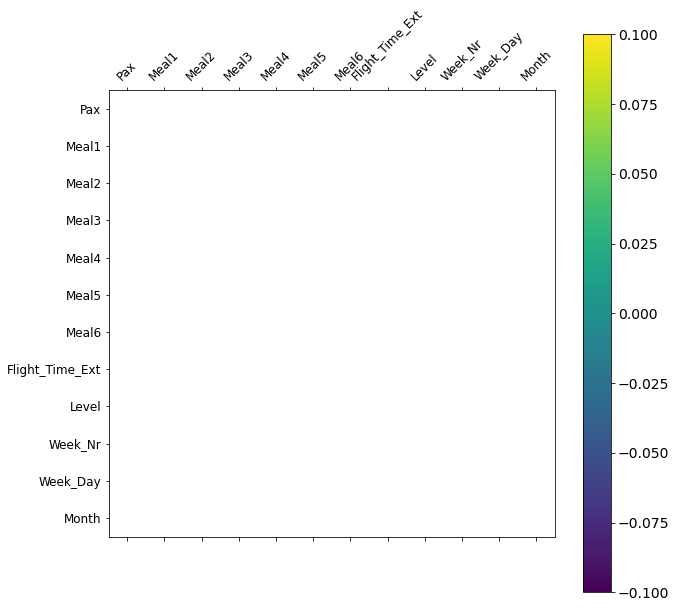

In [0]:
numeric_columns = ['Pax', 'Meal1', 'Meal2', 'Meal3', 'Meal4','Meal5', 'Meal6',
                   'Flight_Time_Ext', 'Level', 'Week_Nr', 'Week_Day', 'Month']
f = plt.figure(figsize=(10, 10))
plt.matshow(consumption_raw_data[numeric_columns].corr(), fignum=f.number)
plt.xticks(range(len(numeric_columns)), consumption_raw_data[numeric_columns], fontsize=12, rotation=45)
plt.yticks(range(len(numeric_columns)), consumption_raw_data[numeric_columns], fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

#### scatter matrices to easily visualise any trends in our data. 

ValueError: ignored

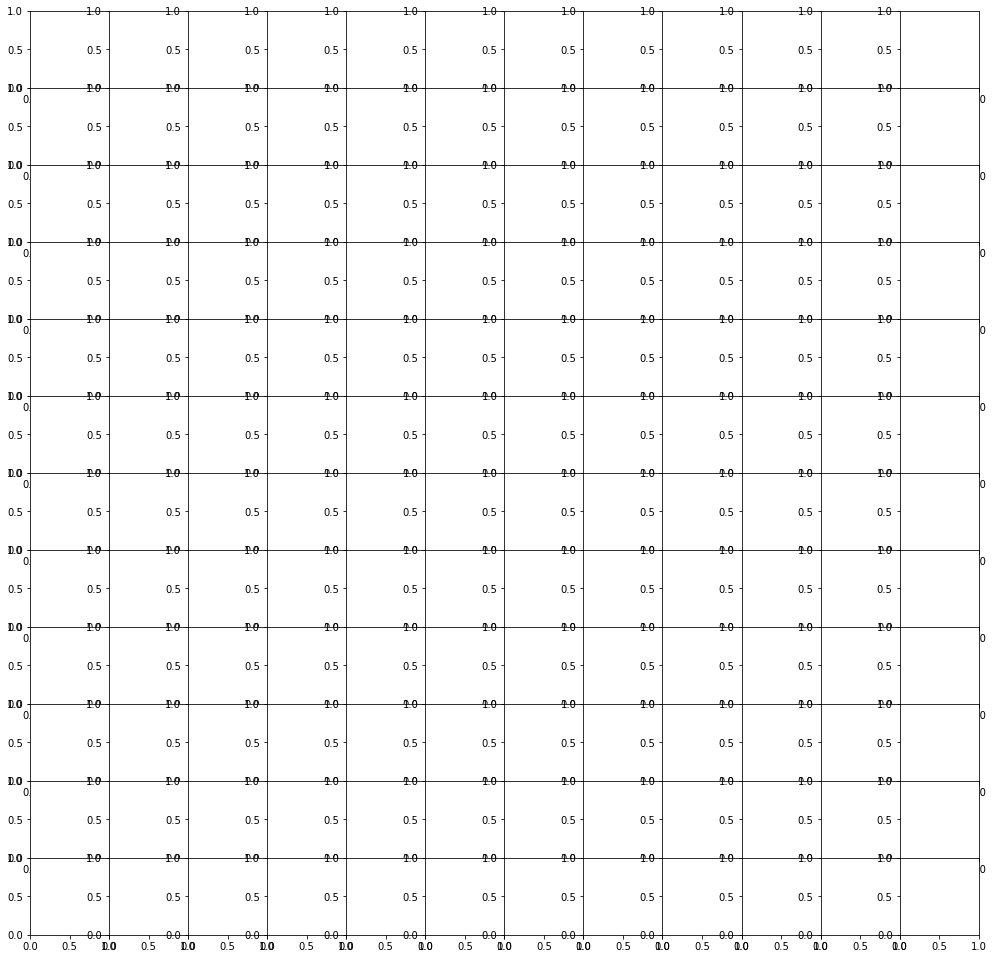

In [0]:
from pandas.plotting import scatter_matrix
scatter_matrix(consumption_raw_data[numeric_columns], alpha=0.2, figsize=(17, 17), diagonal='kde')
plt.show()


#### It seems that pax is a big factor in predicting meals

In [0]:
consumption_raw_data_copy['Total consum']= consumption_raw_data_copy.iloc[:, 7:13].sum(axis=1)
consumption_raw_data_copy.head(3)

,To Airport,From Airport,index,Flight Day,Flight Number,Arrival Time,Departure Time,Pax,Meal1,Meal3,Meal4,Meal6,Meal5,Meal2,Flight_Time,Flight_Minutes,Week_Day,Week_Nr,Month,Level,Flight_Time_Ext,Dep_Longitude,Dep_Latitude,Arr_Longitude,Arr_Latitude,Departure_Hour,Total consum
0,DME,GVA,18,2019-11-01,LX1336,13:35,08:00,58.0,4.0,1.0,0.0,2.0,0.0,0.0,05:35:00,335.0,4,44,11,3.0,3.360646,6.10895,46.238098,37.90630,55.408798,8,65.0
1,GVA,DME,19,2019-11-01,LX1337,16:15,14:20,109.0,4.0,6.0,0.0,0.0,0.0,6.0,01:55:00,115.0,4,44,11,3.0,3.527771,37.90630,55.408798,6.10895,46.238098,14,119.0
2,PRG,GVA,20,2019-11-01,LX1472,09:40,08:10,136.0,0.0,0.0,0.0,0.0,0.0,0.0,01:30:00,90.0,4,44,11,2.0,1.212434,6.10895,46.238098,14.26000,50.100800,8,136.0


#### It seems that flights with high level consumed more meals that the others

In [0]:
consumption_raw_data_copy.groupby(['Level'])['Total consum'].sum()

Level
1.0       314.0
2.0    210224.0
3.0    119063.0
Name: Total consum, dtype: float64

#### Barplot graph showing the consumed meals for each flight level

In [0]:
consum_per_level = consumption_raw_data_copy.groupby(['Level'])['Total consum'].sum()
import plotly.express as px
fig = px.bar(consum_per_level, x = consum_per_level.index, y = consum_per_level.values,
             labels={'x':'Level','y':'Total consum'})
fig.show()

#### Barplot graph showing the consumed meals for each path

In [0]:
consumption_raw_data_copy['path']= consumption_raw_data_copy['From Airport'] + ' To '  + consumption_raw_data_copy['To Airport']
consum_per_path = consumption_raw_data_copy.groupby(['path'])['Total consum'].sum()

fig = px.bar(consum_per_path, x = consum_per_path.index, y = consum_per_path.values,
             labels={'x':'path','y':'Total consum'})
fig.show()

####  To see if there is a positive correlation between being in a flight for a long time and eating meals

In [0]:
consum_per_Flight_Minutes = consumption_raw_data_copy.groupby(['Flight_Time_Ext'])['Total consum'].sum()
fig = px.scatter(x=consum_per_Flight_Minutes.index, y=consum_per_Flight_Minutes.values,
                labels={'x':'Flight_Minutes', 'y':'Total consum'})
fig.show()

# Splitting the Data

In [0]:
consumption_raw_data.head(3)

,To Airport,From Airport,index,Flight Day,Flight Number,Arrival Time,Departure Time,Pax,Meal1,Meal3,Meal4,Meal6,Meal5,Meal2,Flight_Time,Flight_Minutes,Week_Day,Week_Nr,Month,Level,Flight_Time_Ext,Dep_Longitude,Dep_Latitude,Arr_Longitude,Arr_Latitude,Departure_Hour
0,DME,GVA,18,2019-11-01,LX1336,13:35,08:00,58.0,4.0,1.0,0.0,2.0,0.0,0.0,05:35:00,335.0,4,44,11,3.0,3.360646,6.10895,46.238098,37.90630,55.408798,8
1,GVA,DME,19,2019-11-01,LX1337,16:15,14:20,109.0,4.0,6.0,0.0,0.0,0.0,6.0,01:55:00,115.0,4,44,11,3.0,3.527771,37.90630,55.408798,6.10895,46.238098,14
2,PRG,GVA,20,2019-11-01,LX1472,09:40,08:10,136.0,0.0,0.0,0.0,0.0,0.0,0.0,01:30:00,90.0,4,44,11,2.0,1.212434,6.10895,46.238098,14.26000,50.100800,8


In [0]:
# # training data
start_date_train = "2019-11-01"
end_date_train= "2020-01-31"

# test data
start_date_test = "2020-02-01"
consumption_raw_data['path']= consumption_raw_data['From Airport'] + ' To '  + consumption_raw_data['To Airport']
consumption_train = consumption_raw_data[(consumption_raw_data['Flight Day'] >= start_date_train) & (consumption_raw_data['Flight Day'] <= end_date_train)]
consumption_test = consumption_raw_data[consumption_raw_data['Flight Day'] >= start_date_test]

print(consumption_raw_data.shape, consumption_train.shape, consumption_test.shape)

(3360, 27) (2537, 27) (823, 27)


In [0]:
consumption_test.tail(10)

,To Airport,From Airport,index,Flight Day,Flight Number,Arrival Time,Departure Time,Pax,Meal1,Meal3,Meal4,Meal6,Meal5,Meal2,Flight_Time,Flight_Minutes,Week_Day,Week_Nr,Month,Level,Flight_Time_Ext,Dep_Longitude,Dep_Latitude,Arr_Longitude,Arr_Latitude,Departure_Hour,path
3350,LHR,GVA,5648,2020-02-29,LX352,08:15,07:25,84.0,1.0,0.0,0.0,1.0,0.0,0.0,00:50:00,50.0,5,9,2,2.0,1.485761,6.108950,46.238098,-0.461941,51.470600,7,GVA To LHR
3351,GVA,LHR,5649,2020-02-29,LX353,11:35,08:55,129.0,0.0,0.0,1.0,1.0,0.0,0.0,02:40:00,160.0,5,9,2,2.0,1.331677,-0.461941,51.470600,6.108950,46.238098,8,LHR To GVA
3352,LHR,GVA,5650,2020-02-29,LX354,13:40,12:45,84.0,3.0,0.0,0.0,0.0,1.0,2.0,00:55:00,55.0,5,9,2,2.0,1.476695,6.108950,46.238098,-0.461941,51.470600,12,GVA To LHR
3353,GVA,LHR,5651,2020-02-29,LX355,17:05,14:25,119.0,0.0,0.0,0.0,0.0,0.0,0.0,02:40:00,160.0,5,9,2,2.0,1.382098,-0.461941,51.470600,6.108950,46.238098,14,LHR To GVA
3354,LHR,GVA,5652,2020-02-29,LX356,18:40,17:55,83.0,2.0,0.0,0.0,0.0,0.0,0.0,00:45:00,45.0,5,9,2,2.0,1.402920,6.108950,46.238098,-0.461941,51.470600,17,GVA To LHR
3355,GVA,LHR,5653,2020-02-29,LX357,22:05,19:30,56.0,0.0,0.0,0.0,0.0,0.0,0.0,02:35:00,155.0,5,9,2,2.0,1.448249,-0.461941,51.470600,6.108950,46.238098,19,LHR To GVA
3356,LHR,GVA,5654,2020-02-29,LX358,21:25,20:50,102.0,0.0,0.0,0.0,0.0,0.0,2.0,00:35:00,35.0,5,9,2,2.0,1.342821,6.108950,46.238098,-0.461941,51.470600,20,GVA To LHR
3357,GVA,LHR,5655,2020-02-29,LX359,08:35,07:00,115.0,0.0,0.0,0.0,0.0,0.0,0.0,01:35:00,95.0,5,9,2,2.0,1.304301,-0.461941,51.470600,6.108950,46.238098,7,LHR To GVA
3358,LCY,GVA,5658,2020-02-29,LX434,11:30,10:55,83.0,1.0,0.0,0.0,0.0,0.0,1.0,00:35:00,35.0,5,9,2,2.0,1.320940,6.108950,46.238098,0.055278,51.505299,10,GVA To LCY
3359,GVA,LCY,5659,2020-02-29,LX435,14:35,12:00,99.0,4.0,1.0,0.0,0.0,0.0,2.0,02:35:00,155.0,5,9,2,2.0,1.350638,0.055278,51.505299,6.108950,46.238098,12,LCY To GVA


In [0]:
consumption_test.head(10)

,To Airport,From Airport,index,Flight Day,Flight Number,Arrival Time,Departure Time,Pax,Meal1,Meal3,Meal4,Meal6,Meal5,Meal2,Flight_Time,Flight_Minutes,Week_Day,Week_Nr,Month,Level,Flight_Time_Ext,Dep_Longitude,Dep_Latitude,Arr_Longitude,Arr_Latitude,Departure_Hour,path
2537,ARN,GVA,4283,2020-02-01,LX1232,15:20,12:30,127.0,5.0,1.0,0.0,0.0,0.0,4.0,02:50:00,170.0,5,5,2,3.0,2.371486,6.108950,46.238098,17.918600,59.651901,12,GVA To ARN
2538,GVA,ARN,4284,2020-02-01,LX1233,18:35,16:00,110.0,2.0,3.0,0.0,0.0,2.0,3.0,02:35:00,155.0,5,5,2,3.0,2.350067,17.918600,59.651901,6.108950,46.238098,16,ARN To GVA
2539,GOT,GVA,4285,2020-02-01,LX1236,16:15,13:55,130.0,1.0,1.0,0.0,0.0,0.0,0.0,02:20:00,140.0,5,5,2,3.0,1.987282,6.108950,46.238098,12.279800,57.662800,13,GVA To GOT
2540,GVA,GOT,4286,2020-02-01,LX1237,19:15,17:00,101.0,2.0,0.0,0.0,0.0,0.0,2.0,02:15:00,135.0,5,5,2,3.0,1.937590,12.279800,57.662800,6.108950,46.238098,17,GOT To GVA
2541,LED,GVA,4287,2020-02-01,LX1304,14:45,09:25,108.0,4.0,5.0,0.0,4.0,0.0,2.0,05:20:00,320.0,5,5,2,3.0,2.972557,6.108950,46.238098,30.262501,59.800301,9,GVA To LED
2542,GVA,LED,4288,2020-02-01,LX1305,17:00,15:40,131.0,5.0,0.0,0.0,0.0,1.0,4.0,01:20:00,80.0,5,5,2,3.0,3.124364,30.262501,59.800301,6.108950,46.238098,15,LED To GVA
2543,DME,GVA,4289,2020-02-01,LX1336,15:15,09:40,101.0,2.0,0.0,0.0,0.0,0.0,2.0,05:35:00,335.0,5,5,2,3.0,3.360646,6.108950,46.238098,37.906300,55.408798,9,GVA To DME
2544,GVA,DME,4290,2020-02-01,LX1337,17:55,16:00,103.0,3.0,3.0,0.0,0.0,2.0,4.0,01:55:00,115.0,5,5,2,3.0,3.527771,37.906300,55.408798,6.108950,46.238098,16,DME To GVA
2545,PRN,GVA,4291,2020-02-01,LX1430,08:30,06:20,116.0,0.0,0.0,0.0,0.0,0.0,0.0,02:10:00,130.0,5,5,2,2.0,1.882685,6.108950,46.238098,21.035801,42.572800,6,GVA To PRN
2546,GVA,PRN,4292,2020-02-01,LX1431,11:40,09:20,129.0,1.0,1.0,0.0,0.0,0.0,0.0,02:20:00,140.0,5,5,2,2.0,1.973086,21.035801,42.572800,6.108950,46.238098,9,PRN To GVA


# Model Fitting

In [0]:
# feature_names = ["Pax", "Flight_Minutes", "Level", "path"]
feature_names = ["Pax", "Flight_Time_Ext", "Dep_Longitude", "Dep_Latitude","Arr_Longitude"	,"Arr_Latitude", "Departure_Hour","Week_Day", "Week_Nr", "Month"]


In [0]:
X = consumption_train[feature_names]
y = consumption_train['Meal1']

X_feb = consumption_test[feature_names]
y_feb = consumption_test['Meal1']



In [0]:
# X = pd.get_dummies(X, columns=["path"])
# X_feb = pd.get_dummies(X_feb, columns=["path"])

#### To solve the problem of non matching number of features

In [0]:
# print('Before train data feaures ', X.shape[1], 'test data features ', X_feb.shape[1])
# X, X_feb = X.align(X_feb, join='inner', axis=1)  # inner join
# print('After train data feaures ', X.shape[1], 'test data features ', X_feb.shape[1])

data_dmatrix = xgb.DMatrix(data=X,label=y)

#### Using cross validation with 5 as number of folds because the number of samples are very low to split it into validation set and also to get the best hyperparamters for this problem

In [0]:
params = {'colsample_bytree': 1, 'gamma': 0.06, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 35, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.9}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params ,metrics="rmse", as_pandas=True, seed=123, nfold=5, num_boost_round = 35)

print (cv_results.head())

print("Last RMSE: ",cv_results["test-rmse-mean"].tail(1).values[0])

   train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0         1.776580        0.010294        1.783349       0.035307
1         1.561476        0.009433        1.573693       0.029736
2         1.432520        0.010799        1.454251       0.033296
3         1.354286        0.007456        1.384484       0.041811
4         1.307040        0.008539        1.341380       0.047044
Last RMSE:  1.2327464


In [0]:
xg_reg = xgb.XGBRegressor(**params, objective = 'reg:squarederror')
xg_reg.fit(X,y)

train_preds = xg_reg.predict(X)

mse = mean_squared_error(y, train_preds)
print("RSE: %f" % (mse))

RSE: 1.239208


In [0]:
rmse = np.sqrt(mean_squared_error(y, train_preds))
print("RMSE: %f" % (rmse))

RMSE: 1.113197


# Testing Data

In [0]:
test_preds = xg_reg.predict(X_feb)
mse = mean_squared_error(y_feb, test_preds)
print("RSE: %f" % (mse))


RSE: 1.632831


In [0]:
rmse = np.sqrt(mean_squared_error(y_feb, test_preds))
print("RMSE: %f" % (rmse))

RMSE: 1.277823


# MultiOutputRegressor for multible regression points

In [0]:
  # from sklearn.multioutput import MultiOutputRegressor

  # X = consumption_train[feature_names]
  # y = consumption_train[['Meal1', 'Meal2','Meal3', 'Meal4', 'Meal5', 'Meal6']]

  # X_feb = consumption_test[feature_names]
  # y_feb = consumption_test[['Meal1', 'Meal2','Meal3', 'Meal4', 'Meal5', 'Meal6']]

  # X = pd.get_dummies(X, columns=["path"])
  # X_feb = pd.get_dummies(X_feb, columns=["path"])

In [0]:
# # random forest for multioutput regression
# from sklearn.ensemble import RandomForestRegressor

# # define model
# model = RandomForestRegressor()

# # fit model
# model.fit(X, y)

In [0]:
# # make a prediction
# yhat = model.predict(X)